# Dinosaur Name Generation

Generating dinosaur names using a character-level language model with RNNs.

_PyTorch implementation of the assignment of Course 5 of Coursera's Deep Learning Specialization_.

## Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Reproducibility

In [2]:
seed = 24
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed);

## Device Configuration

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Dataset

We will create a custom dataset that will provide the following:

- Each sample is each **character** of a dinosaur name
- Each corresponding target is a **character** of the same name, shifted one to the right
  - We shift the characters because we want to predict the next most likely character given some previous character
- 1536 training examples
- 19909 total characters
- 27 unique characters in our vocabulary (a-z and the terminal `\n` character)

We will also define two mappings to track character-to-index and index-to-character values of our vocabulary. This will help us build the training set (using indices) and sample new names (using characters).

_Note: We won't be using a `DataLoader` because it requires all samples to be the same size. In this case, the dinosaur names are of variable length. There are ways of padding and packing the samples so that they are all of the same size (see: https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e). However, the size of this dataset is small enough to train efficiently without batches._

In [4]:
vocab_size = 27

data = open('data/dinos.txt', 'r').read()
data = data.lower()
chars = sorted(list(set(data)))

char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

In [5]:
with open('data/dinos.txt', 'r') as f:
    names = [n.lower().strip() for n in f.readlines()]

# Generate the training examples with the indices for each character of each name
samples = [[char_to_ix[ch] for ch in name] for name in names]
# Generate the targets by shifting the values (i.e. start from index 1 instread of 0) and adding the terminal character
targets = [sample[1:] + [char_to_ix['\n']] for sample in samples]
# Zip them into a single list of sample-target pairs
training = list(zip(samples, targets))

## Model

We'll use a vanilla Recurrent Neural Network with a **single** recurrent layer with **50 units**, and a **softmax** output function at _each_ RNN cell. This means our model expects $T_x = T_y$, i.e. the length of the input sequence should match the length of the target sequence. The reason is that we are generating a character-level model using the _same_ name as both input and target (shifted).

For the input, the model will one-hot encode the character indices based on the size of our vocabulary (28 characters).

![](img/rnn.png)

In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # RNN layer expects one-hot encoded sequences of size `vocab_size`
        self.rnn = nn.RNN(input_size=vocab_size, hidden_size=50, batch_first=True)
        # Output layer to convert to target space (`vocab_size` character classes)
        self.out = nn.Linear(in_features=50, out_features=vocab_size)
        # We don't define a softmax output layer explicitly because it's combined with the loss function

    def forward(self, input, hidden):
        # One-hot the input
        output = F.one_hot(input, num_classes=vocab_size).float()
        # Pass through RNN along with the previous hidden activations
        # Passing in the previous hidden activations is needed for the model to continue learning
        # if they aren't passed, the activations are reset to zero which effectively erases any learnings from the model!
        output, hidden = self.rnn(output, hidden)
        # Stack outputs from RNN (i.e. batch_size * seq_len, hidden_size) and convert to target space
        # In this case batch_size=1
        output = self.out(output.contiguous().view(-1, 50))

        return output, hidden

In [7]:
model = Model()
print(model)

Model(
  (rnn): RNN(27, 50, batch_first=True)
  (out): Linear(in_features=50, out_features=27, bias=True)
)


## Sampling

In order to generate dinosaur names, we will sample characters from our model according to their softmax distribution.

In [8]:
# Max number of characters in a name
# As mentioned in the Deep Learning Specialization assignment, this should be unlikely with a well-trained model but it's a safety measure
max_chars = 50

def sample_name(model):
    # Initialize the input as a sample with value zero of size (batch_size=1, seq_len=1)
    input = torch.zeros([1, 1], dtype=torch.int64)
    # The hidden activations are initialize to all zeroes by default when `None` is passed
    hidden = None

    name = ""
    char = ''
    chars = 0

    # Make sure to not record any computation in the graph since the model is being used for inference here!
    with torch.no_grad():
        while char != '\n' and chars < max_chars:
            output, hidden = model(input.to(device), hidden)
            output = output.detach().cpu()

            # Compute the distribution using the softmax function
            probs = F.softmax(output, dim=1)
            # We squeeze the output to effectively convert it into a vector
            probs = probs.numpy().squeeze()
            
            # Sample the character based on its distribution
            # We normalize the probabilities by their sum to make sure they always sum to 1; this is needed because NumPy is very strict
            idx = np.random.choice(list(range(vocab_size)), p=probs / probs.sum())

            # Save the actual character and continue building the name
            char = ix_to_char[int(idx)]
            name += char

            # The sampled character becomes the input to the next timestep
            # Make sure to add the batch_size=1 and seq_len=1 dimensions
            input = torch.tensor(idx).unsqueeze(0).unsqueeze(1)

            chars += 1

    return name

## Optimization

We'll use Adam for training the model with the cross-entropy loss. As in the Deep Learning Specialization assignment, we will also smooth the loss to accelerate training.

In [9]:
loss_fn =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [10]:
def smooth(prev_loss, loss):
    # Taken from `utils.py` as part of the Deep Learning Specialization assignment
    return prev_loss * 0.999 + loss * 0.001

## Training

Time to train the model!

In [11]:
# Training configuration
epochs = 35000
dino_names = 7

[0/35000]	Loss: 23.051048278808594
Tikcuyz
Mqfcdstrhf
Lqrolicxvcviujnivndauiutsknmjjuqqvbksr
Nyijubjlwqmwrp
Muzrsqucupsnqnscuesmxpdgxncufnscaevrdae
Ljhdugt
Uwqvpwsefitqnlcyjizofdhb


[2000/35000]	Loss: 4.896327972412109
Esaulosonnablochives
Imoputpolnlntonmanoblptysaurus
Ilnholvalus
Llldoththtingphus
Osbunposan
Llenglis
Saropthalmus


[4000/35000]	Loss: 2.39034104347229
Longlkioatopalopawaun
Aoris
Oon
Torngugiauditapavocltitarlgocopapr
Oduwx
Awapelpolix
Anjos


[6000/35000]	Loss: 2.0113978385925293
Velaeor
Ipcrutrosannulbantisaurus
Xintan
Odosatodledous
Aonysaurus
Ocodun
Elodosaurosaus


[8000/35000]	Loss: 1.9952290058135986
Ostliausmodmosaenzisaurus
Elkostus
Odadiestamas
Orgag
Amhofophrargas
Osakanescenasanhuseutoshus
Utor


[10000/35000]	Loss: 2.0411453247070312
A
Eiauloa
Eatxpurosyusjirateryopaurus
Ylutabagochylesaurus
Aunthhaavocervurosaurus
Alovajeelos
Imodopsymachusaurus


[12000/35000]	Loss: 2.0199317932128906
Aus
Ys
Ators
Uabrrkuukaqus
Aule
Aus
Overocryus


[14000/35000]	Loss: 

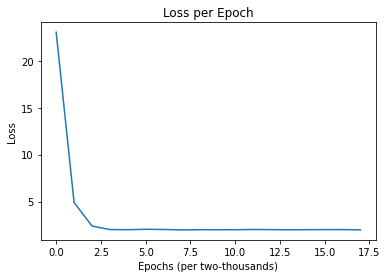

In [12]:
# Main training loop
model = model.to(device)
# Make sure to shuffle the examples
np.random.shuffle(training)
# Initialize loss as in the Deep Learning Specialization assignment
prev_loss = -np.log(1. / vocab_size) * dino_names
losses = []
# The hidden state is initialized to zeroes when `None` is passed
hidden = None

for epoch in range(epochs):
    optimizer.zero_grad()

    # Grab an example
    sample, target = training[epoch % len(training)]
    # Add the batch_size=1 dimension
    sample = torch.tensor(sample).unsqueeze(0).to(device)
    target = torch.tensor(target).to(device)
    
    output, hidden = model(sample, hidden)

    loss = loss_fn(output, target)
    loss = smooth(prev_loss, loss)
    
    loss.backward()

    # Clip gradients using a max value of 5 as in the Deep Learning Specialization assignment
    nn.utils.clip_grad_norm_(model.parameters(), 5)

    optimizer.step()
    
    # Detach the loss to avoid saving more computations on it since we'll only use it for smoothing the next loss
    prev_loss = loss.detach().cpu().numpy()
    # Detach the hidden activations to avoid saving more computations on it since we'll only use it for initializing the next RNN sequence
    # If we don't detach PyTorch tries to backprop through all the history of hidden activations which isn't allowed since the resources are freed
    hidden = hidden.detach()
    
    if epoch % 2000 == 0:
        print(f'[{epoch}/{epochs}]\tLoss: {loss}')
        losses.append(loss)

        # Generate some dinosaur names to see if the model is learning
        for _ in range(dino_names):
            name = sample_name(model)
            print(f'{name[0].upper() + name[1:]}', end='')

        print('\n')

# Save the model
torch.save(model.state_dict(), 'model/model.pt')

# Plot the losses
plt.plot(np.squeeze(losses))
plt.ylabel('Loss')
plt.xlabel('Epochs (per two-thousands)')
plt.title('Loss per Epoch')
plt.show()

## Testing

Now that we have trained our model, we can use it to sample new dinosaur names.

In [13]:
# Load the trained model
model = Model()
model.load_state_dict(torch.load('model/model.pt'))
# Always set the mode to `eval` for inference
model.eval()
model = model.to(device)

# Names to generate
num_names = 10
# The generated dinosaur names
names = []

for _ in range(num_names):
    name = sample_name(model)
    names.append(name)

# Display all dinosaur names capitalized
for name in names:
    print(f'{name[0].upper() + name[1:]}', end='')

Asaurotreus
Osia
Olodosaus
Oangesaurus
Epia
Eponator
Epurontaurus
Nochacrusus
Osaurus
Anosauptor


The model was able to learn that dinosaur names tend to end in _saurus_, _don_, _aura_, _tor_, etc!